## Import

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import maxflow

from scipy.ndimage import convolve, affine_transform
from skimage.feature import peak_local_max

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'

## 5.2 MRF modelling for image segmentation

1. Get hold of the gray-scale image D and one configuration for the segmentation $S$. To begin with, this may be a ground truth segmentation. Notice that a ground truth segmentation (labeling) is not the same as a noise-free image: elements of the segmentation are labels $1, 2, . . .$ while elements of the noise-free image are pixel intensities $µ1, µ2, . . .$

2. For computing $V_1$ you need $D$, $S$ and $\mu$. First, compute an intensity-realization of $S$, that is an image where each occurrence of label $f_i$ is
replaced by $\mu(f_i)$. It is then easy to compute $V_1$ as a sum of squared differences.

3. For computing $V_2$ you need $S$ and $\beta$. Recall that an almost identical problem was solved in week 1.

4. Produce some other configurations $S$, by any means that you find appropriate: thresholding, manually drawing, modifying ground truth... Apply your two functions to all configurations, and display the likelihood, prior and posterior for every configuration.

5. If we consider only the likelihood, which configuration is the most probable? If we consider only the prior energy, which configuration is the most probable? What if we consider the posterior energy?

6. Would you expect that minimizing the posterior energy leads to a good segmentation? If not, try adjusting $\beta$.

In [32]:
image_noise_free = get_gray_image_255(PATH + 'noise_free_circles.png')
image_noisy = get_gray_image_255(PATH + 'noisy_circles.png')

Text(0.5, 1.0, 'Noisy image')

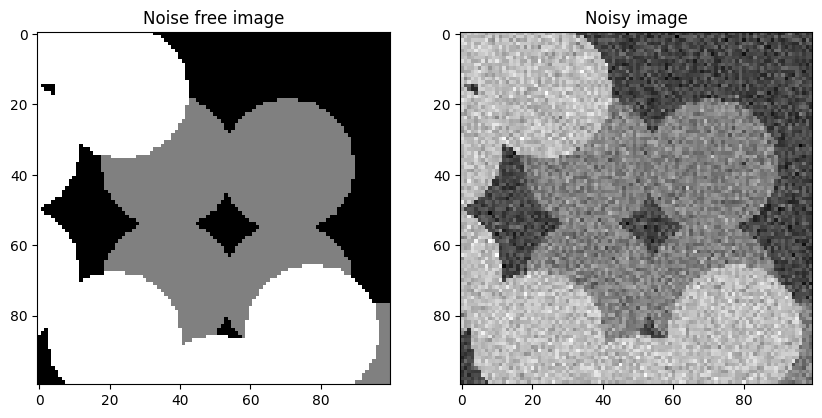

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image_noise_free, cmap='gray')
ax[0].set_title('Noise free image')
ax[1].imshow(image_noisy, cmap='gray')
ax[1].set_title('Noisy image')

In [34]:
def plot_image_and_label(image_noise_free, S):
    """
    Plots the noise-free image and the segmented image side by side with a legend.

    Parameters:
        image_noise_free (numpy.ndarray): The noise-free grayscale image.
        S (numpy.ndarray): The segmented image with labels for each pixel.

    Returns:
        None
    """
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(image_noise_free, cmap='gray')
    ax[0].set_title('Noise free image')
    im = ax[1].imshow(S)
    ax[1].set_title('Segmented image')

    # Create a legend for the segmented image with corresponding pixel values
    colors = [im.cmap(im.norm(value)) for value in np.unique(S)]
    labels = [f'Category {i} (Pixel value: {np.unique(image)[i]})' for i in np.unique(S)]
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    ax[1].legend(patches, labels, loc='upper right')

def compute_V1(D, S, mu):
    """
    Computes the V1 energy term as the sum of squared differences between 
    the original grayscale image D and the intensity-realized version of S.

    Parameters:
        D (numpy.ndarray): The original grayscale image.
        S (numpy.ndarray): The segmentation (labels for each pixel).
        mu (dict): A dictionary mapping labels to mean intensities.

    Returns:
        float: The computed V1 energy.
    """
    # Create the intensity-realized image of S
    intensity_realized_S = np.vectorize(mu.get)(S) #Maps where the value of S is the key in mu to the value in mu which is the mean intensity of the label
    
    # Compute sum of squared differences
    V1 = np.sum((D - intensity_realized_S) ** 2)
    
    return V1

def compute_V2(S, beta):
    """
    Computes the V2 energy term as the sum of differences between neighboring pixels."
    """
    check_vertically   = beta*np.sum((S[1:, :] != S[:-1,:])) #Check if the pixel below is different from the pixel above
    check_horizontally = beta*np.sum((S[:, 1:] != S[:,:-1]))
    return check_vertically + check_horizontally

The unique values in the noisy image are: [0 1 2]
The unique values in the noise free image are: [ 70 130 190]

The likelihood energy term V1 is: 0.0
The prior term V2 is: 64300
The posterior energy term V1+V2 is: 64300.0


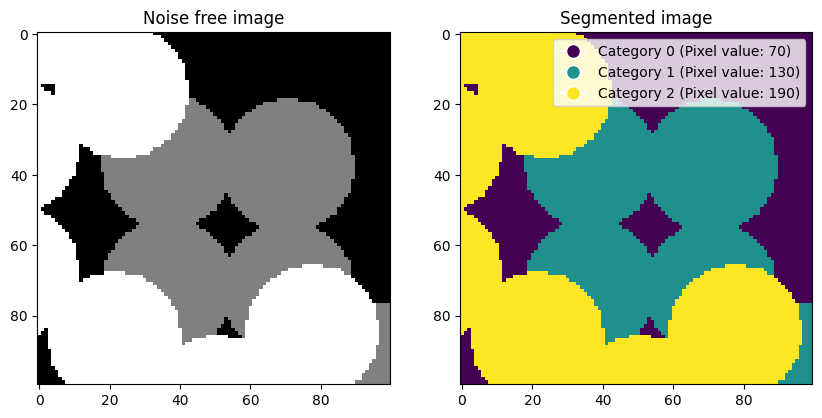

In [35]:
image = image_noise_free

labels = np.unique(image)
S_threshold = np.zeros_like(image)
S_threshold[image > 100] = 1

S = np.zeros_like(image)
for i, label in enumerate(labels):
    S[image == label] = i

print(f'The unique values in the noisy image are: {np.unique(S)}')
print(f'The unique values in the noise free image are: {labels}\n')

BETA = 100
mu_fi = {i: np.mean(image[S == i]) for i in np.unique(S)}
V1, V2 = compute_V1_and_V2(image, S, mu_fi, BETA)

plot_image_and_label(image, S)


**Creating new S matrix**

The unique values in the noisy image are: [0 1]
The unique values in the noise free image are: [ 70 130]

The likelihood energy term V1 is: 6479439.879896275
The prior term V2 is: 45800
The posterior energy term V1+V2 is: 6525239.879896275


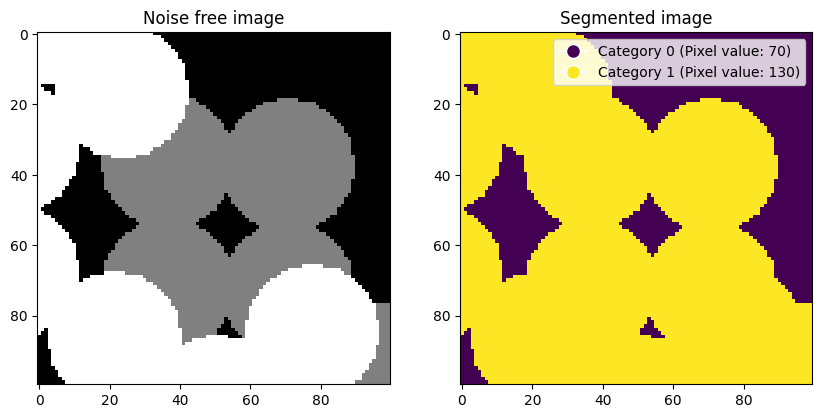

In [36]:
image = image_noise_free

# Get the first to labels
labels = np.unique(image)[:2] 
S = np.zeros_like(image)
S[image > 100] = 1

for i, label in enumerate(labels):
    S[image == label] = i

print(f'The unique values in the noisy image are: {np.unique(S)}')
print(f'The unique values in the noise free image are: {labels}\n')

BETA = 100
mu_fi = {i: np.mean(image[S == i]) for i in np.unique(S)}
V1, V2 = compute_V1_and_V2(image, S, mu_fi, BETA)

plot_image_and_label(image, S)


## 5.3 Graph cuts for optimizing MRF

**Setting up the problem**

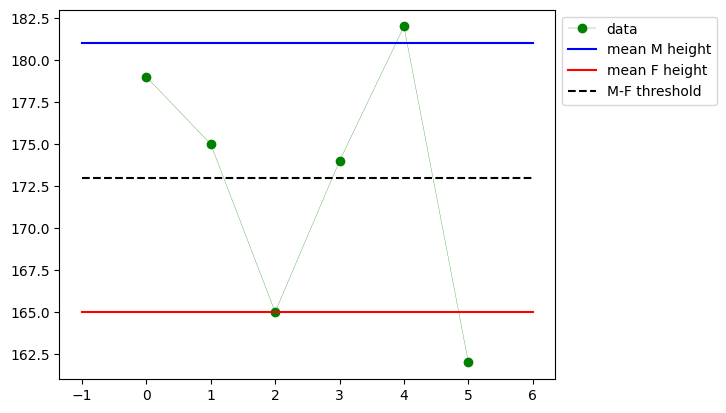

In [44]:
#d = np.array([179, 174, 182, 162, 175, 165]) # heights (data term)
d = np.array([179,  175, 165, 174, 182, 162]) # heights (data term)

mu = [181, 165] # means of two classes, used for computation of likelihood
w_s = (d - mu[0]) ** 2 # source weight
w_t = (d - mu[1]) ** 2 # sink weights

fig, ax = plt.subplots()
ax.plot(d, '-og', lw=0.2, label='data')
ax.plot([-1, len(d)], [mu[0]]*2, 'b', label='mean M height')
ax.plot([-1, len(d)], [mu[1]]*2, 'r', label='mean F height')
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k', label='M-F threshold')
ax.legend(bbox_to_anchor = (1, 1))
plt.show()

Solving the assignment problem using graph-cut

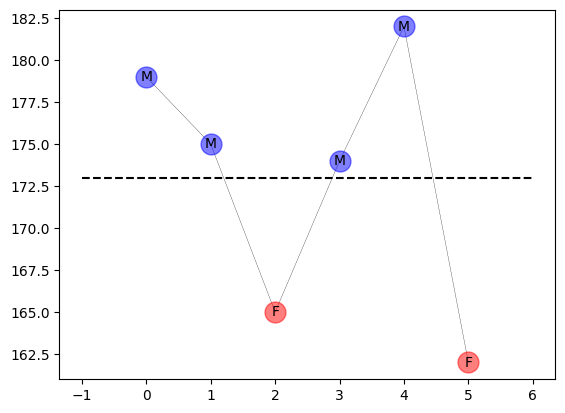

In [47]:

beta = 100  # try changing between 0 and 1000

# Create a graph with integer capacities.
g = maxflow.Graph[int]()

# Add (non-terminal) nodes and retrieve an index for each node.
nodes = g.add_nodes(len(d))

# Create edges between nodes.
for i in range(len(d)-1):
    g.add_edge(nodes[i], nodes[i+1], beta, beta)

# Set the capacities of the terminal edges.
for i in range(len(d)):
    g.add_tedge(nodes[i], (d[i] - mu[1]) ** 2, (d[i] - mu[0]) ** 2)

# Run the max flow algorithm.
flow = g.maxflow()

# Get the result as integer labels.
labeling = [g.get_segment(n) for n in nodes]

# Visualize
fig, ax = plt.subplots()
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k')
ax.plot(d, '-k', lw=0.2)
for i, di in enumerate(d):
    color = 'b' if labeling[i] == 0 else 'r'
    letter = 'M' if labeling[i] == 0 else 'F'
    ax.plot(i, di, 'o', color=color, alpha=0.5, markersize=15)
    ax.text(i, di, letter, ha='center', va='center')
plt.show()